## 2. Create 2D Occupancy grid

In [45]:
import open3d as o3d
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
import cv2
from skimage.draw import line

In [46]:
# Step 1: Load the PLY file
point_cloud = o3d.io.read_point_cloud("cleaned_maze.ply") #week 1 maze


In [47]:
""" Visualise filtered point cloud"""
o3d.visualization.draw_geometries([point_cloud]) 

In [48]:
"""flatten z coordinates"""
point_cloud_np = np.asarray(point_cloud.points) 
# point_cloud_np = point_cloud_np[:, [0,2]] #removes z dimension
point_cloud_np[:, 1] = 0 # sets z dimension to 0

print(point_cloud_np[0, :])

[-5.19326019  0.         -9.71401978]


In [49]:
"""Show flattened maze"""
flattened_pc = o3d.geometry.PointCloud()
flattened_pc.points = o3d.utility.Vector3dVector(point_cloud_np)

o3d.visualization.draw_geometries([flattened_pc]) 

### Create Grid

In [50]:
import numpy as np

# Indices: y at 0, z at 1, x at 2.
# only use x and y

y_coords = point_cloud_np[:, 0]
x_coords = point_cloud_np[:, 2]

resolution = 0.2 # grid size

# min and max points
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)

# Compute the size of the grid
x_size = int(np.ceil((x_max - x_min) / resolution))
y_size = int(np.ceil((y_max - y_min) / resolution))


#count number of points per grid cell
count_grid = np.zeros((y_size, x_size), dtype=np.int32)
for i in range(len(x_coords)):
    # Translate coordinates to grid indices
    x_idx = int((x_coords[i] - x_min) / resolution)
    y_idx = int((y_coords[i] - y_min) / resolution)
    count_grid[y_idx, x_idx] += 1


#if more points in cell than threshold, mark as occupied
threshold = 5
grid = np.zeros_like(count_grid, dtype=np.uint8)
grid[count_grid >= threshold] = 1 #initialise grid, 0 = free, 1 = occupied


print("Grid shape:", grid.shape)


Grid shape: (85, 65)


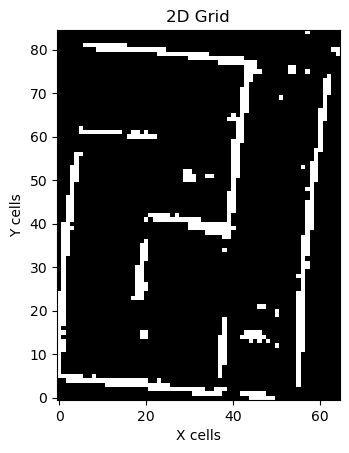

In [51]:
import matplotlib.pyplot as plt

plt.imshow(grid, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Grid')
plt.show()

#TODO need to rotate to the left right after loading the point cloud (in filter_keypoints)


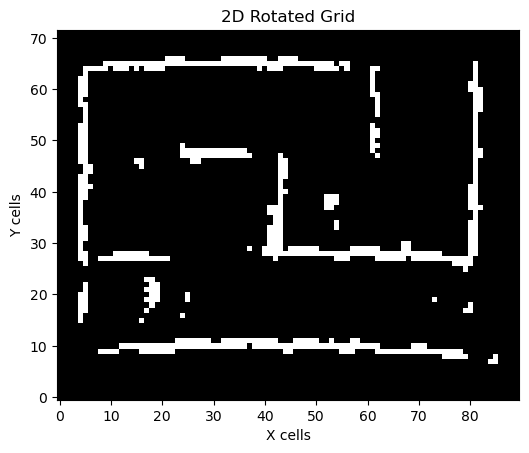

In [52]:
# Perform Hough Transform
hspace, angles, distances = hough_line(grid)
# Find peaks in the Hough transform
_, peak_angles, _ = hough_line_peaks(hspace, angles, distances)

# Normalize angles to 0-180 degrees
normalized_angles = np.rad2deg(peak_angles) % 180

# Create histogram of angles
hist, bins = np.histogram(normalized_angles, bins=180, range=(0, 180))

# Find the two largest peaks in the histogram
peaks = np.argsort(hist)[-1]  # Indices of two largest bins
theta_h = bins[peaks]

rotation_angle = (theta_h - 90)
(h, w) = grid.shape[:2]
center = (w // 2, h // 2)

# Compute the bounding box of the rotated image
cos_theta = np.abs(np.cos(np.deg2rad(rotation_angle)))
sin_theta = np.abs(np.sin(np.deg2rad(rotation_angle)))
new_w = int((h * sin_theta) + (w * cos_theta))
new_h = int((h * cos_theta) + (w * sin_theta))

# Adjust the rotation matrix to account for the translation
M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
M[0, 2] += (new_w - w) / 2
M[1, 2] += (new_h - h) / 2

# Perform the rotation
rotated = cv2.warpAffine(grid, M, (new_w, new_h))

plt.imshow(rotated, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()

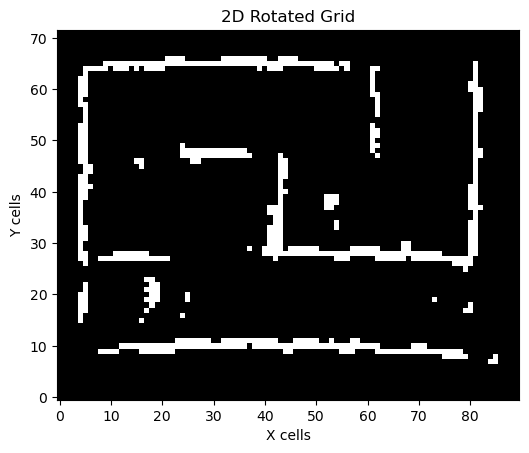

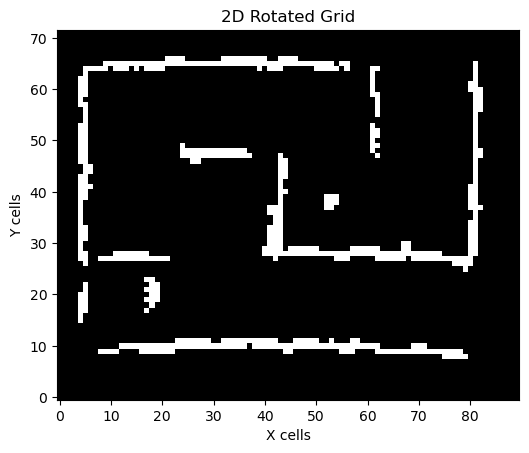

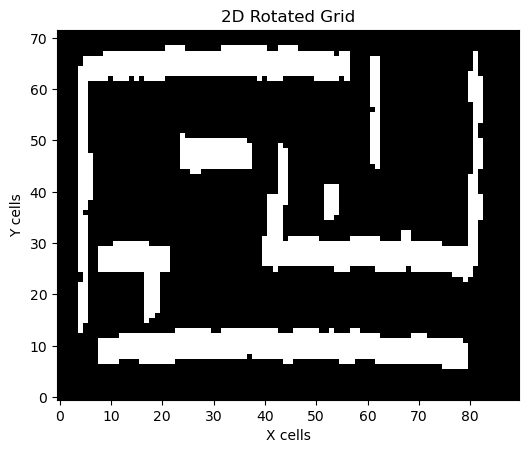

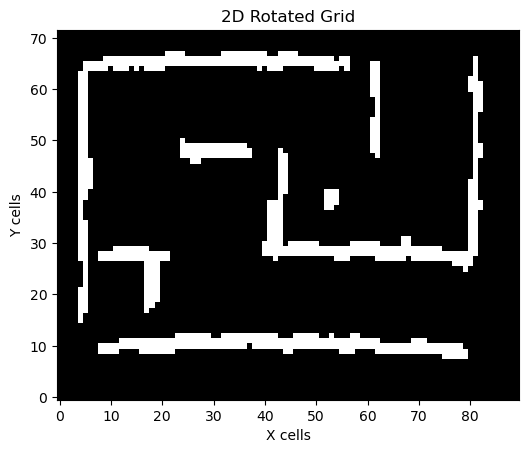

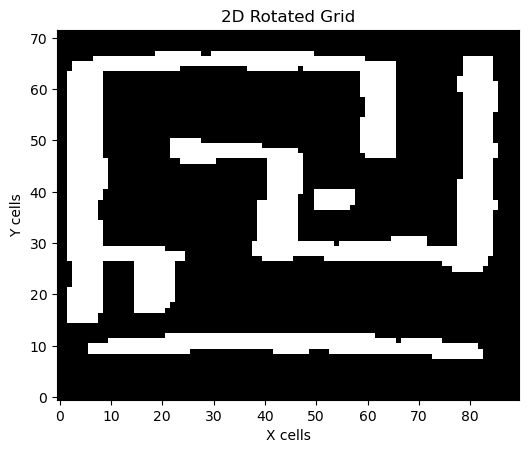

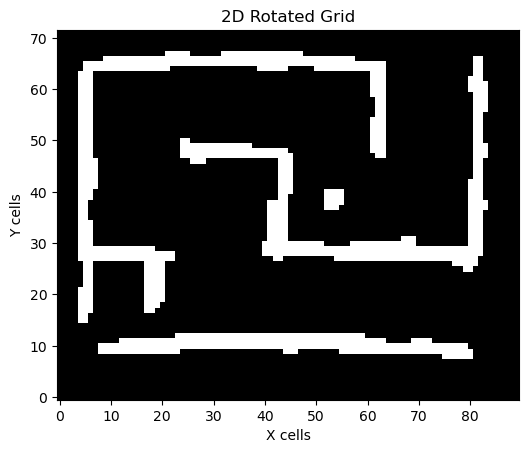

In [86]:
plt.imshow(rotated, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()

# Remove isolated pixels
connectivity = 8
output = cv2.connectedComponentsWithStats(rotated, connectivity, cv2.CV_32S)

num_stats = output[0] # total number of connected components
labels = output[1] # labeled version of the image where each component is assigned a unique integer label
stats = output[2] # statistics about each component (including its area, bounding box, and other properties).

new_image = rotated.copy()

for label in range(num_stats):  # foes through each connected component
    if stats[label,cv2.CC_STAT_AREA] == 1 or stats[label,cv2.CC_STAT_AREA] == 2 or stats[label,cv2.CC_STAT_AREA] == 3  :
        new_image[labels == label] = 0
plt.imshow(new_image, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()


# Dilation
kernel_dilation_v = np.ones((5,1), np.uint8)
dilated_image_v = cv2.dilate(new_image, kernel_dilation_v, iterations=1)

plt.imshow(dilated_image_v, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()

# Erosion
kernel_erosion = np.ones((4,1), np.uint8)
eroded_image2 = cv2.erode(dilated_image_v, kernel_erosion, iterations=1)

plt.imshow(eroded_image2, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()



# Dilation
kernel_dilation_h = np.ones((1, 6), np.uint8)
dilated_image_h = cv2.dilate(eroded_image2, kernel_dilation_h, iterations=1)

plt.imshow(dilated_image_h, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()

# Erosion
kernel_erosion = np.ones((1,5), np.uint8)
eroded_image = cv2.erode(dilated_image_h, kernel_erosion, iterations=1)

plt.imshow(eroded_image, cmap='gray', origin='lower')
plt.xlabel('X cells')
plt.ylabel('Y cells')
plt.title('2D Rotated Grid')
plt.show()

